In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [3]:

# Download tensorflow eurosat dataset
(train, test), info = tfds.load('eurosat/all', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)
assert isinstance(train, tf.data.Dataset)
print(train)

sample = train.take(1)


for image, label in tfds.as_numpy(sample):
    print(type(image), type(label), label)

print(info.features)

print('Train test split sizes: ')
print('Train: ', len(train))
print('Test: ', len(test))


<PrefetchDataset shapes: ((64, 64, 13), ()), types: (tf.float32, tf.int64)>
<class 'numpy.ndarray'> <class 'numpy.int64'> 8
FeaturesDict({
    'filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'sentinel2': Tensor(shape=(64, 64, 13), dtype=tf.float32),
})
Train test split sizes: 
Train:  21600
Test:  5400


In [4]:
input_dim = (64, 64, 13)

train.element_spec

(TensorSpec(shape=(64, 64, 13), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights=None, input_shape=input_dim, pooling='max', classes=10
)

keras.optimizers.Adam(learning_rate=0.001)

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Niels\.virtualenvs\uc-landcover-types--9lkH9oZ\lib\site-packages\keras\applications\resnet.py:135: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 13)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 13)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   40832       ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']      

### Attempt 1: Use a batchsize schedule
On our computers this runs out of memory, as a tensor of size 3200 * 70 * 70 * 13 already requires a sie of 1.6GB

In [6]:
BATCH_SIZE_SCHEDULER = False

if BATCH_SIZE_SCHEDULER:
    batch_sizes = [128, 640, 3200, 16_000]
    epochs = [60, 60, 40, 40]
    hist = None
    for epoch_set, batch_size in zip(epochs, batch_sizes):
        h1 = model.fit(train.batch(batch_size), epochs=epoch_set, validation_data=test.batch(batch_size))
        if hist is None:
            hist = pd.DataFrame(h1.history)
            print(hist.head())
        else:
            hist = hist.append(pd.DataFrame(h1.history))


### Attempt 2: Use a custom learning rate scheduler
This is known to be significantly slower, but atleast it is possible to train the network on our computers this way

In [7]:
BATCH_SIZE = 256
INITIAL_LR = 0.001
LR_BREAKPOINTS = [50, 100, 200, 250]

def custom_lr_scheduler(epoch, lr):
    if epoch in LR_BREAKPOINTS:
        return lr / 5
    return lr

log_dir = 'training-logs'
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
scheduler = keras.callbacks.LearningRateScheduler(custom_lr_scheduler)

hist = model.fit(train.batch(BATCH_SIZE), epochs=200, validation_data=test.batch(BATCH_SIZE), callbacks=[scheduler, tensorboard_callback])

Epoch 1/200


C:\Users\Niels\.virtualenvs\uc-landcover-types--9lkH9oZ\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


85/85 [==============================] - 30s 241ms/step - loss: 3.0807 - accuracy: 0.2748 - val_loss: 6.2186 - val_accuracy: 0.1211 - lr: 0.0010
Epoch 2/200
85/85 [==============================] - 20s 216ms/step - loss: 1.5019 - accuracy: 0.5150 - val_loss: 6.6219 - val_accuracy: 0.0885 - lr: 0.0010
Epoch 3/200
85/85 [==============================] - 19s 220ms/step - loss: 1.3995 - accuracy: 0.5465 - val_loss: 4.6653 - val_accuracy: 0.3178 - lr: 0.0010
Epoch 4/200
85/85 [==============================] - 19s 224ms/step - loss: 1.1300 - accuracy: 0.6840 - val_loss: 7.1782 - val_accuracy: 0.0509 - lr: 0.0010
Epoch 5/200
85/85 [==============================] - 19s 224ms/step - loss: 1.4768 - accuracy: 0.5508 - val_loss: 6.1846 - val_accuracy: 0.2146 - lr: 0.0010
Epoch 6/200
85/85 [==============================] - 19s 218ms/step - loss: 1.8774 - accuracy: 0.3994 - val_loss: 7.5262 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/200
85/85 [==============================] - 19s 218ms/ste

In [3]:
model_name = 'resnet50_eurosat_model_lr_2'

In [8]:
# Save the model

model.save(f'resnet-50/{model_name}/')

INFO:tensorflow:Assets written to: resnet-50/resnet50_eurosat_model_lr_2/assets


INFO:tensorflow:Assets written to: resnet-50/resnet50_eurosat_model_lr_2/assets
C:\Users\Niels\.virtualenvs\uc-landcover-types--9lkH9oZ\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Niels\.virtualenvs\uc-landcover-types--9lkH9oZ\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [9]:
# Save history
pd.DataFrame(hist.history).to_csv(f'resnet-50/{model_name}/history.csv')

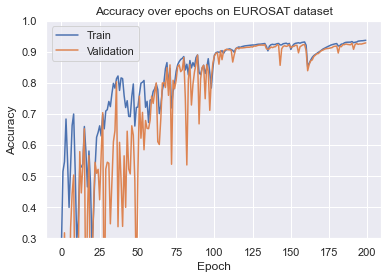

In [14]:

sns.set_theme()
results_df = pd.read_csv(f'resnet-50/{model_name}/history.csv')

sns.lineplot(x=results_df.index, y=results_df['accuracy'])
sns.lineplot(x=results_df.index, y=results_df['val_accuracy'])
plt.ylim(0.3,1.0)
plt.yticks(np.arange(0.3, 1.1, step=0.1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy over epochs on EUROSAT dataset')
plt.savefig(f'resnet-50/{model_name}/resnet50_accuracy.pdf')